In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 221 (delta 108), reused 197 (delta 91), pack-reused 0
Receiving objects: 100% (221/221), 64.85 MiB | 31.43 MiB/s, done.
Resolving deltas: 100% (108/108), done.


---

In [1]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/MHealth'

In [2]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import SMReader
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-2-458494cb613a>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [4]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "MHEALTH",
    "Model": "SOTAEmbedding",
    "model_params":{
        "linear_filters":[256,256,256,400],
        "input_feat": 24,
        "dropout":0.1,
    },
    "lr": 0.0001,
    "n_epochs": 20,
    "optimizer": "adam",
    "batch_size": 32,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [5]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [6]:
IMU_data_path = data_root+'/IMU/mhealth_raw_data.csv'
dataReader = SMReader(IMU_data_path)
actionList = dataReader.idToLabel

/content/src/datasets/data.py:2451: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [7]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [8]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [9]:
video_feat.shape

(12, 400)

In [10]:
vid_cls_name = np.unique(video_classes)

In [11]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [12]:
class SOTAEmbedding(nn.Module):
    def __init__(self, linear_filters=[1024,1024,1024,2048], input_feat=36, dropout=0.1):
        super(SOTAEmbedding, self).__init__()
        self.input_feat = input_feat
        self.linear_filters = linear_filters
        self.input_feat = input_feat
        self.dropout = dropout

        self.linear1 = nn.Linear(input_feat,linear_filters[0])
        self.batch_norm1 = nn.BatchNorm1d(linear_filters[0])
        self.linear2 = nn.Linear(linear_filters[0],linear_filters[1])
        self.batch_norm2 = nn.BatchNorm1d(linear_filters[1])
        self.linear3 = nn.Linear(linear_filters[1],linear_filters[2])
        self.batch_norm3 = nn.BatchNorm1d(linear_filters[2])
        self.linear4 = nn.Linear(linear_filters[2]+linear_filters[1]+linear_filters[0],linear_filters[3])
        self.batch_norm4 = nn.BatchNorm1d(linear_filters[3])
        self.act = F.relu



    def forward(self, x):
        #layer1
        out1 = self.linear1(x)
        out1 = self.batch_norm1(out1)
        out1 = self.act(out1)

        #layer2
        out2 = self.linear2(out1)
        out2 = self.batch_norm2(out2)
        out2 = self.act(out2)

        #layer3
        out3 = self.linear3(out2)
        out3 = self.batch_norm3(out3)
        out3 = self.act(out3)

        concat = torch.cat([out1,out2,out3],-1)

        #layer4
        out4 = self.linear4(concat)
        out4 = self.batch_norm4(out4)
        out4 = self.act(out4)
        return out4

In [14]:
model = SOTAEmbedding(
    linear_filters=config["model_params"]["linear_filters"],
    input_feat=config["model_params"]["input_feat"],
    dropout=config["model_params"]["dropout"]
)

emb = model(torch.randn((32,24)))
emb.size()

torch.Size([32, 400])

---

In [15]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
actionList

['Standing still',
 'Sitting and relaxing',
 'Lying down',
 'Walking',
 'Climbing stairs',
 'Waist bends forward',
 'Frontal elevation of arms',
 'Knees bending (crouching)',
 'Cycling',
 'Jogging',
 'Running',
 'Jump front & back']

In [17]:
# run 5-fold running
fold_classes = [['Standing still', 'Climbing stairs', 'Cycling'], ['Sitting and relaxing', 'Waist bends forward', 'Jogging'], ['Lying down', 'Frontal elevation of arms', 'Running'], ['Walking', 'Knees bending (crouching)', 'Jump front & back']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [18]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [19]:
selecting_video_prototypes(video_feat,video_classes,vid_cls_name).shape

torch.Size([12, 400])

In [20]:
dataReader.label_map

[(1, 'Standing still'),
 (2, 'Sitting and relaxing'),
 (3, 'Lying down'),
 (4, 'Walking'),
 (5, 'Climbing stairs'),
 (6, 'Waist bends forward'),
 (7, 'Frontal elevation of arms'),
 (8, 'Knees bending (crouching)'),
 (9, 'Cycling'),
 (10, 'Jogging'),
 (11, 'Running'),
 (12, 'Jump front & back')]

In [21]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [22]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)

In [23]:
data_dict['train']['X'].shape,data_dict['eval-seen']['X'].shape,data_dict["test"]["X"].shape

((1600, 24), (400, 24), (774, 24))

In [24]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [25]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [26]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            # convert feature vector into action class
            # using cosine
            if phase == 'seen':
                pred_action = class_output
            else:
                #feat_numpy = torch.sigmoid(feat_output.cpu().detach())
                #action_probs = cosine_similarity(feat_numpy, target_feat_met)
                pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [27]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

================ Fold-0 ================
Unseen Classes : ['Standing still', 'Climbing stairs', 'Cycling']
seen classes >  [1, 2, 3, 5, 6, 7, 9, 10, 11]
unseen classes >  [0, 4, 8]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.812



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.859



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.859



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.898



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.914



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.898



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.906



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.961



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.984



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.977



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.992



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.984



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.984



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.984



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.984



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.992



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/17 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



unseen:   0%|          | 0/9 [00:00<?, ?batch/s]

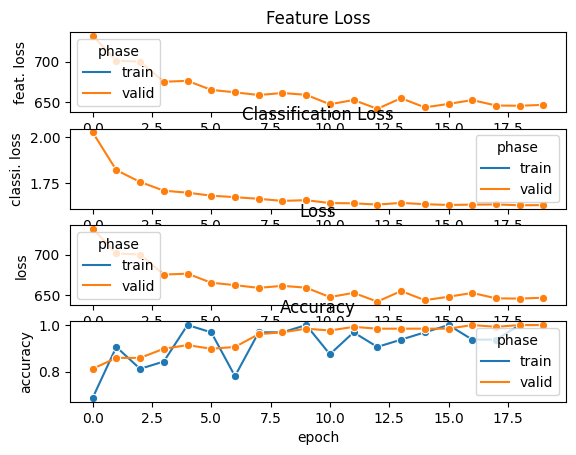

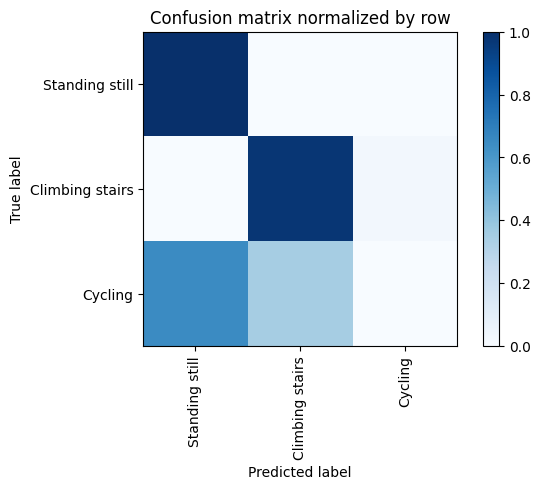

Overall accuracy: 0.681

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Climbing stairs       0.779      0.973      0.865      0.389        112|	 Cycling: 0.027,	Standing still: 0.000,	
        Cycling       0.000      0.000      0.000      0.309         89|	 Standing still: 0.652,	Climbing stairs: 0.348,	
 Standing still       0.600      1.000      0.750      0.302         87|	 Cycling: 0.000,	Climbing stairs: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.484      0.681      0.563        1.0        288|	      

{'accuracy': 0.6805555555555556, 'precision': 0.4595238095238095, 'recall': 0.6577380952380952, 'f1': 0.5383597883597884, 'samples': 288, 'loss': 161847.10546875, 'feat. loss': 161847.076171875, 'classi. loss': 266.1477165222168}
================ Fold-1 ================
Unseen Classes : ['Sitting and relaxing', 'Waist bends forward', 'Jogging']
see

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.836



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.852



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.891



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.898



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 1.000



unseen:   0%|          | 0/8 [00:00<?, ?batch/s]

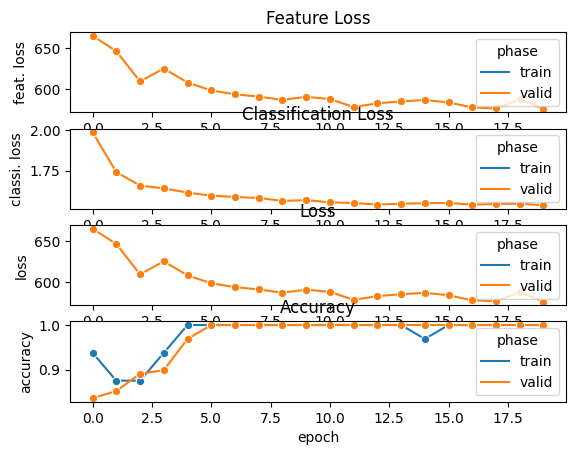

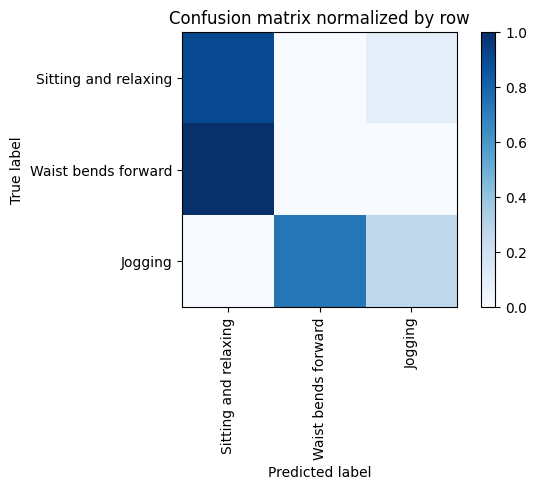

Overall accuracy: 0.410

                       precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Sitting and relaxing       0.513      0.900      0.653      0.352         90|	 Jogging: 0.100,	Waist bends forward: 0.000,	
             Jogging       0.727      0.270      0.393      0.348         89|	 Waist bends forward: 0.730,	Sitting and relaxing: 0.000,	
 Waist bends forward       0.000      0.000      0.000      0.301         77|	 Sitting and relaxing: 1.000,	Jogging: 0.000,	

----------------------------------------------------------------------------------------------------
         avg / total       0.433      0.410      0.366        1.0        256|	      

{'accuracy': 0.41015625, 'precision': 0.4133103183736095, 'recall': 0.38988764044943824, 'f1': 0.34888947646747753, 'samples': 256, 'loss': 157341.328125, 'feat. loss': 157341.296875, 'classi. loss': 269.87940979003906}
================ Fold-2 ================
Unseen Classes : ['Lying down', 'Frontal ele

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.625



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.750



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.852



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.891



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.859



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.883



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.891



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.875



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.891



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.914



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.938



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.961



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.953



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.945



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.930



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.930



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.953



train:   0%|          | 0/18 [00:00<?, ?batch/s]

seen:   0%|          | 0/4 [00:00<?, ?batch/s]

Overall accuracy: 0.938



unseen:   0%|          | 0/8 [00:00<?, ?batch/s]

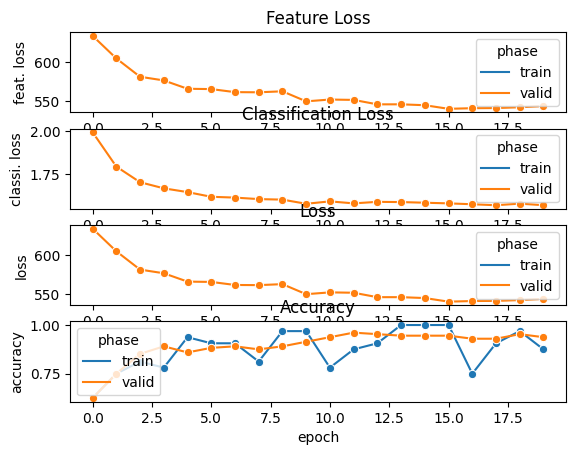

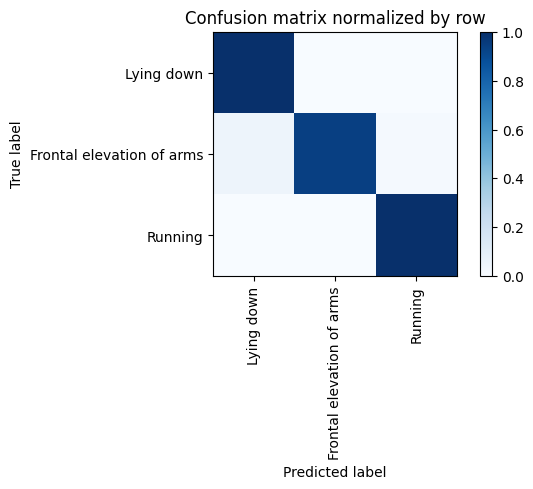

Overall accuracy: 0.980

                            precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

                  Running       0.989      1.000      0.994      0.348         89|	 Frontal elevation of arms: 0.000,	Lying down: 0.000,	
               Lying down       0.956      1.000      0.978      0.340         87|	 Running: 0.000,	Frontal elevation of arms: 0.000,	
Frontal elevation of arms       1.000      0.938      0.968      0.312         80|	 Lying down: 0.050,	Running: 0.013,	

----------------------------------------------------------------------------------------------------
              avg / total       0.981      0.980      0.980        1.0        256|	      

{'accuracy': 0.98046875, 'precision': 0.9816442816442817, 'recall': 0.9791666666666666, 'f1': 0.9798944777309134, 'samples': 256, 'loss': 211788.279296875, 'feat. loss': 211788.263671875, 'classi. loss': 182.50245475769043}
================ Fold-3 ================
Unseen Classes : ['Walk

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.725



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.738



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.781



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.894



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.925



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.950



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.944



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.963



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.969



train:   0%|          | 0/20 [00:00<?, ?batch/s]

seen:   0%|          | 0/5 [00:00<?, ?batch/s]

Overall accuracy: 0.969



unseen:   0%|          | 0/5 [00:00<?, ?batch/s]

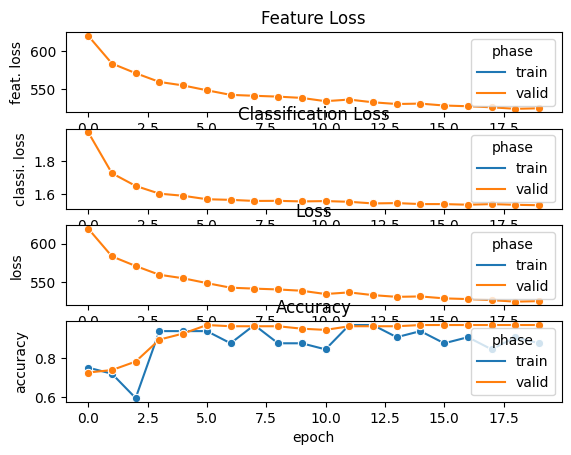

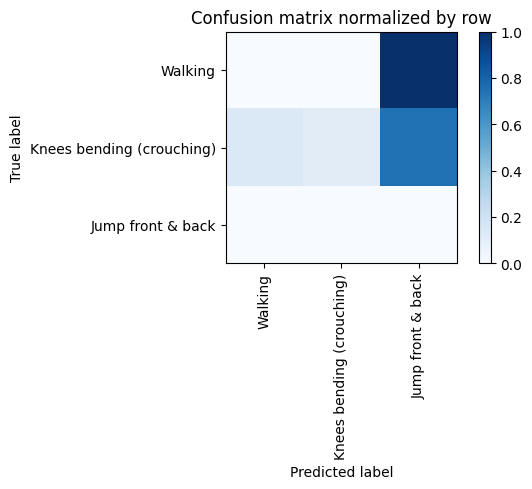

Overall accuracy: 0.050

                            precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

                  Walking       0.000      0.000      0.000      0.544         87|	 Jump front & back: 1.000,	Knees bending (crouching): 0.000,	
Knees bending (crouching)       1.000      0.110      0.198      0.456         73|	 Jump front & back: 0.753,	Walking: 0.137,	
        Jump front & back       0.000      0.000      0.000      0.000          0|	 Knees bending (crouching): 0.000,	Walking: 0.000,	

----------------------------------------------------------------------------------------------------
              avg / total       0.456      0.050      0.090        1.0        160|	      

{'accuracy': 0.05, 'precision': 0.3333333333333333, 'recall': 0.0365296803652968, 'f1': 0.06584362139917695, 'samples': 160, 'loss': 129950.67578125, 'feat. loss': 129950.65625, 'classi. loss': 192.77999877929688}
============== Overall Unseen Classes Performance ==========

accuracy             0.530295
precision            0.546953
recall               0.515831
f1                   0.483247
samples            240.000000
loss            165231.847168
feat. loss      165231.823242
classi. loss       227.827395
dtype: float64

In [28]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=12, window_overlap=10, resample_freq=50)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    model = SOTAEmbedding(
        linear_filters=config["model_params"]["linear_filters"],
        input_feat=config["model_params"]["input_feat"],
        dropout=config["model_params"]["dropout"]
    )
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-5)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
